## Import modules

In [1]:
### Import standard Packages

import itertools
import math
import time
import numpy as np
from easydict import EasyDict as edict
import tempfile
import pandas as pd
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr




In [2]:
##If you are using colab, make sure to send the binary_stochastic_neurons on your gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
%cd /content/gdrive/MyDrive/Stage_M2_Jean-Eudes
!pwd

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes
/content/gdrive/MyDrive/Stage_M2_Jean-Eudes


In [4]:

dir_path  = '/content/gdrive/MyDrive/Stage_M2_Jean-Eudes'
dirs = os.listdir(dir_path)

package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/') #binary_stochastic_neurons direcoty
!export PYTHON_PATH=package_path

lib_package_path= os.path.join(package_path,'distributions/')

!export PYTHONPATH=package_path:lib_package_path
!export PYTHON_PATH=package_path:lib_package_path

print (package_path)

os.chdir(package_path)

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/binary-stochastic-neurons-master/


In [1]:
##on local
sys.path.append('../')
sys.path.append('../binary_stochastic_neurons')

In [5]:
### Import packages from https://github.com/Wizaron/binary-stochastic-neurons
from activations import DeterministicBinaryActivation, StochasticBinaryActivation
from utils import Hardsigmoid

In [6]:
use_cuda=True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
CUDA_LAUNCH_BLOCKING=1

In [24]:
print(device)

cuda


In [7]:
n_epochs = 10
batch_size_train = 128
batch_size_test = 256 
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [8]:
os.chdir('/content')

## Data loading and preprocessing

In [9]:

##load data
mnist_train = torchvision.datasets.MNIST(root='.', train=True, download=True,) #'./'
                             #transform=t)

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))

mnist_test = torchvision.datasets.MNIST(root= '.',train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))


##from Swetali codes

from numpy.fft import fftshift, ifftshift, fftn, ifftn


def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img
  
def transform_image_to_kspace(img, dim=None, k_shape=None):
  """ Computes the Fourier transform from image space to k-space space
  along a given or all dimensions
  :param img: image space data
  :param dim: vector of dimensions to transform
  :param k_shape: desired shape of output k-space data
  :returns: data in k-space (along transformed dimensions)
  """
  if not dim:
      dim = range(img.ndim)

  k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim) 
  #k /= np.sqrt(np.prod(np.take(img.shape, dim)))
  return k


class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, input_1):
        self.x_mnist_data = x_mnist_data
        
        self.input_1 = input_1

        
    def __getitem__(self, index):
        sample = {'x_mnist_data': self.x_mnist_data[index], 'input_1': self.input_1[index]}
        return sample
    
    def __len__(self):
        return len(self.x_mnist_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
## We normalize by the max of real and imaginary absolute values. In test time, we will rescale by multiplying by the max
class own_minmaxscaler:

  def __init__(self, base_scaler=MinMaxScaler()):
    self.base_scaler = base_scaler


  def fit(self,train_data):
      assert train_data.ndim ==2 and  train_data.shape[1]==1 and np.iscomplexobj(train_data)==False ## we want x_train to be of shape [n,1] ==> the complexe [N,1,28,28] should be set to this shape
      self.base_scaler.fit( np.abs(train_data)  ) ## get the min and max by doing : base_scaler.data_max_ ; base_scaler.data_min_

  def transform(self,x):
    return x/self.base_scaler.data_max_

  def inverse_transform(self,x):
    return x*self.base_scaler.data_max_  #rescaling in test time


def transform_data(x_train, x_test, config ,scaler = own_minmaxscaler() ): 
    
    ''' 
        take numpy arrays of train and test set , apply a given trasformation and return their respective data loader and the scaler 
    '''
    
  config = edict(config) ## facilitate the use of dictionary convert the keys of the dict into attributes
  ##x_train, x_test are typically  the raw mnist data divided by 255 : X_train_mnist and X_test_mnist
    
  train_size = x_train.shape[0]
  test_size= x_test.shape[0]

  if config.shift_type == "tr_img_ksp": # tr_img_ksp = transform image to kspace
      x_train = transform_image_to_kspace(x_train, dim=(2,3)) ## fftshift -> fftn -> ifftshift

      x_test = transform_image_to_kspace(x_test, dim=(2,3)) 

  elif config.shift_type == "none":

      x_train = np.fft.fft2(x_train, axes=(2,3))

      x_test = np.fft.fft2(x_test, axes=(2,3)) 

  elif config.shift_type == "simple_shift":

      x_train = np.fft.fftshift(np.fft.fft2(x_train, axes=(2,3))) 

      x_test = np.fft.fftshift(np.fft.fft2(x_test, axes=(2,3)))  


  u_train = np.vstack(( np.squeeze(x_train.real), np.squeeze(x_train.imag) ) ).flatten().reshape(-1,1)

  ##normalize kspace
  scaler.fit(u_train); x_train= scaler.transform(x_train) ; x_test= scaler.transform(x_test)

  print("max on train data",scaler.base_scaler.data_max_,"\n","min on train data", scaler.base_scaler.data_min_ )

  ##convert to torch tensor 
  x_train = torch.stack((torch.from_numpy(x_train.real), torch.from_numpy(x_train.imag)),dim=-1).float().to(device) # [60000,28,28,2]
  x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

  dataset = customDataset(x_train, torch.ones((train_size,1,1,1)).float().to(device))
  train_loader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True )

  dataset_test = customDataset(x_test , torch.ones((test_size,1,1,1)).float().to(device))
  test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False )

  return train_loader, test_loader , scaler ##I return the scale , so that in prediction time I could rescale the predicted values

## Define winner takes all layer

In [11]:

##see https://github.com/a554b554/kWTA-Activation/blob/master/kWTA/models.py
## check also https://discuss.pytorch.org/t/k-winner-take-all-advanced-indexing/24348/4

class SparsifyBase(nn.Module):
    def __init__(self, sparse_ratio=0.5):
        super(SparsifyBase, self).__init__()
        self.sr = sparse_ratio
        self.preact = None
        self.act = None

    def get_activation(self):
        def hook(model, input, output):
            self.preact = input[0].cpu().detach().clone()
            self.act = output.cpu().detach().clone()
        return hook

    def record_activation(self):
        self.register_forward_hook(self.get_activation())      
    

class Sparsify1D_kactiveIOnline(SparsifyBase):
    def __init__(self, config):                                          
        super(Sparsify1D_kactiveIOnline, self).__init__()
                
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.acc = config.acc ## acceleration is expressed as proportion of data to acquire, eg: R= 4 => acc = 0.25 = 1/R
        self.slice_dim = config.slice_dim #tuple or list of the height and width of k-space
        
        self.k = int((self.slice_dim[0]*self.slice_dim[1])*self.acc)  ##number of points to select in the full mask
        self.k_per_under_mask = math.ceil((self.height_mask)*(self.width_mask) * self.k / (self.slice_dim[0]*self.slice_dim[1]))  ##number of points to select in the corresponding local mask
                                              
            
    def forward(self, x):#, k=0):
        #if (k==0):
        #  k = self.k
        #else:
        #  self.k = k
        topval = x.topk(self.k_per_under_mask, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x

## Define "spirit" model

In [12]:

class complexConv2d(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=3, stride=1, padding = 0,dilation=1, groups=1, bias=False):
        
        super(complexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

    def forward(self,input_r, input_i):
        return self.conv_r(input_r)-self.conv_i(input_i), \
               self.conv_r(input_i)+self.conv_i(input_r)


#SPIRiT as single conv layer with kernel(centre) = 0
class Complexspirit2D(nn.Module):
    
    def __init__(self, config):
        
        super(Complexspirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        self.conv1 = complexConv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))
    
    def forward(self, x):
        
        (x_real,x_img) = x[...,0],x[...,1]  
        
        with torch.no_grad():
            self.conv1.conv_r.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
            self.conv1.conv_i.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
        
        (x_real,x_img) = self.conv1(x_real,x_img)
        (x_real,x_img) =(torch.unsqueeze(x_real, 4), torch.unsqueeze(x_img, 4))
        
        return torch.cat((x_real,x_img),-1)

    
    
class ComplexSpiritConvBlock(nn.Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_kspace)
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_kspace, mask) #torch.multiply(x,~mask) + ref_kspace
        
        return out
    
    
#Stack SpiritConv N times
class ComplexstackSpirit(nn.Module):
    def __init__(self, config):
        
        super().__init__() 

        #define local variables
        self.config = config 
        
        #N times spirit is apply
        self.num_stacks = self.config.spirit_block
        
        self.body = nn.ModuleList(
            [ComplexSpiritConvBlock(Complexspirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
        kspace_pred = masked_kspace.clone()

        for stack in self.body:
            kspace_pred = stack(kspace_pred, masked_kspace, mask)
        
        return kspace_pred

## Define noise to add to the model

In [13]:

class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).to(device) * self.stddev)
        return din

## Define the model for mask learning and reconstruction

In [14]:


class Net(nn.Module):

    def __init__(self, bin_act_type = "determinist", k_per_under_mask = 2,config=None):
        super(Net, self).__init__()

        self.img_h = config.slice_dim[0] ##nb rows for the inmput image
        self.img_w = config.slice_dim[1] ##nb col for the inmput image
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.k_per_under_mask = k_per_under_mask
        self.config = config
        self.std_noise = config.std_noise
        self.dropout_proba = config.dropout_proba                

        self.bin_act_type = bin_act_type
        self.conv_mask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (self.height_mask, self.width_mask), groups=1, bias=False)      
        
        self.DO1 = nn.Dropout(p = self.dropout_proba, inplace=False)
        self.noise = GaussianNoise(self.std_noise)

        self.binary_act_d = DeterministicBinaryActivation(estimator='ST')
        self.binary_act_s = StochasticBinaryActivation(estimator='ST')
        
        self.slope = config.slope #1.0
        #self.linear_sp = Sparsify1D_kactiveIOnline(self.height_mask, self.width_mask, k_per_under_mask = self.k_per_under_mask)
        self.linear_sp = Sparsify1D_kactiveIOnline(config) 
        print("Number of acquired points in the whole mask :",self.linear_sp.k ); print(f"Number of acquired points in the local mask of size {config.mask_dim} :",self.linear_sp.k_per_under_mask )
        print(f"acceleration : {self.linear_sp.acc}")


        self.spirit_nn = ComplexstackSpirit(self.config)


    def forward(self, x, my_input_1):

        sig_output = F.sigmoid((self.conv_mask(my_input_1))) ## by giving this "one" input, we will get the parameters of the convoulution layers. by this way, we could use the weight to learn the mask. of course, there may be other ways to proceed    
        
        #sig_output= self.DO1(sig_output) 

        if self.bin_act_type == "determinist": # add noise and use deterministic binary activation 

          sig_output = self.noise(sig_output) 
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output) 
                 
          #wta_output = self.linear_sp(sig_output)        
             
          binary_mask = self.binary_act_d([wta_output, self.slope]) #shape : [batch_size,1,self.height_mask, self.width_mask]. However it is the same mask for all images
        
        elif self.bin_act_type == "stochastic": # don't add noise and use stochastic binary activation 
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output)    
          binary_mask = self.binary_act_s([wta_output, self.slope]) #shape :  [batch_size,1,self.height_mask, self.width_mask], the mask is specific to each input ?


        ##adjust the size of the mask to that of the image : replicate the local pattern                                                                      
        binary_mask_adj = torch.tile(binary_mask[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28
        ##or change the "one" input and rewrite the conv mask with convtranspose  ,with stride = dim of mask...
        
        #print("binary_mask_adj shape: ", binary_mask_adj.shape)
        #print("x avant mul shape: ", x.shape)

      
        stack_binary_mask_adj = torch.stack((binary_mask_adj, binary_mask_adj), dim=-1,)
        #print("stack_binary_mask_adj ", stack_binary_mask_adj.shape) ; print("x.shape :", x.shape)
        x  = torch.mul(stack_binary_mask_adj,x)
        reconstructed_img = self.spirit_nn(x, stack_binary_mask_adj) ##more precisely it is the reconstructed kspace
        print()
                
        return reconstructed_img, binary_mask_adj, binary_mask   ## reconstructed_img more precisely it is the reconstructed kspace

## Define optimizer

In [15]:

def define_opt(network, lr_mask = 1e-3, lr_other = 1e-2,algo =optim.Adam  ):


  my_list = ['conv_mask.weight']

  params = list(filter(lambda kv: kv[0] in my_list, network.named_parameters()))
  base_params = list(filter(lambda kv: kv[0] not in my_list, network.named_parameters()))
  d = dict((y, x) for x, y in base_params)
  #optimizer_mask = optim.Adam(params,lr=0.001)
  #optimizer_model = optim.Adam(base_params,lr=0.01)

  optimizer = algo([ 
                                {'params': d}, 
                                {'params': network.conv_mask.parameters(), 'lr': lr_mask} 
                                ], lr=lr_other)
  return optimizer

## Define test function. It will be used during each epoch

In [47]:

def test_spirit_2(network,criterion,config, loader, scaler, fix_mask=False):

  network.eval()
  test_loss = 0
  output_array =[]
  input_array = []

  #print("*********** TEST *************")
  with torch.no_grad():
    for batch_idx, sample in enumerate(loader):
      input,  ones_data = sample['x_mnist_data'], sample['input_1']
    
      if fix_mask == False :
        output,  learned_mask_adj, learned_mask = network(input,ones_data) ##here the output is the reconstructed kspace
      else:
        output,  learned_mask_adj, learned_mask = network(input) 
      
      #print(f"test : ,{len(output)}")

      if config.normalized_mse == True:
        test_loss += criterion(output, input)/criterion(input,torch.zeros(input.shape).cpu().to(device)).item() ## I am using this formulation to be sure that I divide the sum of sq by the same denominator            

      else :
        test_loss += criterion(output, input).cpu().item()*input.size(0) #criterion_MSE(output, input).item()*input.size(0)

      output_array.append(output) 
      input_array.append(input)        

  if config.normalized_mse == True:
    test_loss /= len(loader)
  else:
    test_loss /= len(loader.dataset) ##this is the loss on the whole test set


  input_array = np.array(torch.vstack(input_array).cpu()) ;   input_array = scaler.inverse_transform(input_array) ##rescaling
  output_array = np.array(torch.vstack(output_array).cpu()) ; output_array = scaler.inverse_transform(output_array) ##rescaling


  if config.shift_type == "none":
    #print("input_array shape: ", input_array.shape)
    input_array_complex = input_array[...,0] +1j*input_array[...,1] 
    input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
    output_array_complex = output_array[...,0] +1j*output_array[...,1]
    output_array = np.fft.ifft2(output_array_complex,axes=(2,3))  #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))


  elif config.shift_type == "simple_shift":
      input_array_complex = input_array[...,0] +1j*input_array[...,1]
      input_array = np.fft.ifft2(np.fft.ifftshift(input_array_complex),axes=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
      output_array_complex = output_array[...,0] +1j*output_array[...,1]
      output_array = np.fft.ifft2(np.fft.ifftshift(output_array_complex),axes=(2,3))  #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))


  elif config.shift_type == "tr_img_ksp":
    input_array_complex = input_array[...,0] +1j*input_array[...,1] 
    input_array = transform_kspace_to_image(input_array_complex, dim=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
    output_array_complex = output_array[...,0] +1j*output_array[...,1]
    output_array = transform_kspace_to_image(output_array_complex, dim=(2,3)) #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))


  
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
  
  #print('\nTest set: Avg. loss: {:.4f}, SSIM: {} on {} test examples\n'.format(
    #test_loss, ssim(output_array, input_array, data_range=output_array.max() - input_array.min()) , len(test_loader_spirit.dataset) ))
  
  if fix_mask == False :
    fig, ax = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(network.conv_mask.weight.data.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    #ax[0].axis("off")
        
    #print(learned_mask.clone().cpu().shape)
    ax[1].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[1].axis("off")
    
    ax[2].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[2].axis("off")
    plt.show()

  else :
    fig, ax = plt.subplots(1,2, figsize=(12,6))
        
    ax[0].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[0].axis("off")
    
    ax[1].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[1].axis("off")
    plt.show()

  return np.abs(input_array), np.abs(output_array), test_loss.item(), learned_mask_adj 

In [43]:

def get_initial_weight_mask(network, data_loader):

  network.eval()

  with torch.no_grad():
    one_batch = next(iter(data_loader))    
    input, ones_data = one_batch['x_mnist_data'], one_batch['input_1']
    init_output, init_learned_mask_adj, init_learned_mask = network(input,ones_data)
    print(input.shape)


  return network.conv_mask.weight.data.clone().cpu()[0,0,:,:], init_learned_mask_adj.clone().cpu()[0,0,:,:]

## Define train function

In [48]:

def train_spirit_2(n_epochs, network, optimizer, config,loader, loader_test , scaler,saving_path = None,criterion=nn.MSELoss().to(device),fix_mask = False ):  
          
                
    train_losses = []
    test_losses = []
    learned_mask_adj_list = []
    weight_list = []
  
    if fix_mask == False :
      init_weight, init_learned_mask_adj = get_initial_weight_mask(network, loader) 
      
      weight_list.append(init_weight); learned_mask_adj_list.append(init_learned_mask_adj)

      plt.imshow(init_learned_mask_adj,cmap = "Greys_r")
      plt.axis("off")
      plt.title("initialisation mask")
      try:
        plt.savefig(os.path.join(saving_path,"initialisation_mask.png")) 
      except:
        pass    

    ##training loop
    for epoch in range(1, n_epochs + 1):
                
        running_loss = 0.0  
        network.train()
        for batch_idx, sample in enumerate(loader):                
            input, ones_data = sample['x_mnist_data'], sample['input_1']
            optimizer.zero_grad()

            if fix_mask == False :
              output,  learned_mask_adj, learned_mask = network(input,ones_data)
            else :
              #print("input",input.get_device())
              output,  learned_mask_adj, learned_mask = network(input)

            #loss = criterion(output, input)      #(sum of square)/batch_size*C*h*w

            if config.normalized_mse == True:
              loss = criterion(output, input)/criterion(input,torch.zeros(input.shape).to(device)) ## I am using this formulation to be sure that I divide the sum of sq by the same denominator            
            else :
              loss = criterion(output, input)  
            
            loss.backward()
            optimizer.step()

            if fix_mask == False : ##capture evolution of the mask
              weight_list.append(network.conv_mask.weight.data.clone().cpu()[0,0,:,:]) ; learned_mask_adj_list.append(learned_mask_adj.clone().cpu()[0,0,:,:])

            #print("nb of pixels changed wrt previous mask : ", (torch.eq(learned_mask_adj_list[-2], learned_mask_adj_list[-1])==False).sum().item() )                        
            #print("nb of pixels changed wrt the initial mask : ", (torch.eq(learned_mask_adj_list[0], learned_mask_adj_list[-1])==False).sum().item()  )
            

            if config.normalized_mse == True:
              running_loss += loss.cpu().item()
            else:
              running_loss += loss.cpu().item() * input.size(0)  #(sum of square)/C*h*w
            
             

            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(input), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item())) # this is the loss for a single batch : (sum of square)/batch_size*C*h*w
                
                #inp, out, _, _ = test_spirit_2(network,criterion,config, loader = loader_test,scaler = scaler,fix_mask=fix_mask) ; plotting_reconst(inp, out,n=4)


        if config.normalized_mse == True:
          epoch_loss = running_loss/len(loader)
        else:
          epoch_loss = running_loss/len(loader.dataset) #(sum of square)/60000*C*h*w; 60000=batch_size*len(train_loader.dataset)

        train_losses.append(epoch_loss)
        print("test at the end of epoch")
        
        inp_, out_, end_test_loss, epoch_learned_mask_adj = test_spirit_2(network,criterion,config, loader = loader_test,scaler = scaler, fix_mask=fix_mask) ; test_losses.append(end_test_loss) 
        
        plt.imshow(epoch_learned_mask_adj[0,0,:,:].cpu(),cmap = "Greys_r")
        plt.axis("off")
        plt.title(f"mask_at_the_epoch_{epoch}")
        try:
          plt.savefig(os.path.join(saving_path,f"mask_at_the_epoch_{epoch}.png")) 
        except:
          pass

    if fix_mask == False :
      delta_pixels = [(torch.eq(learned_mask_adj_list[i], learned_mask_adj_list[i+1])==False).sum().item() \
                      for i in range(len(learned_mask_adj_list)-1)] #list of nb of pixels changed wrt previous mask 

      delta_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i+1]-weight_list[i])))**2).item() \
          for i in range(len(weight_list)-1)] #list of diff in weight wrt previous weight


      delta0_pixels = [(torch.eq(learned_mask_adj_list[0],learned_mask_adj_list[i])==False).sum().item() \
                      for i in range(1,len(learned_mask_adj_list))] #nb of pixels changed wrt the initial mask

      delta0_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i]-weight_list[0])))**2).item() \
                for i in range(1,len(weight_list))]  #list of diff in weight wrt initial weight


      fig, ax = plt.subplots(2,2, figsize=(20,10))

      ax[0,0].plot(range(1,len(delta_pixels)+1), delta_pixels)
      ax[0,0].set_title("nb of pixels changed wrt previous mask")
      ax[0,0].set_xlabel("iterations") # batch_size*nb_epochs
      ax[0,0].set_ylabel("nb of pixels")
      
      ax[0,1].plot(range(1,len(delta_weight)+1),delta_weight)
      ax[0,1].set_title("square diff in weight wrt previous weight")
      ax[0,1].set_xlabel("iterations") 
      ax[0,1].set_ylabel("weight square diff")

      ax[1,0].plot(range(1,len(delta0_pixels)+1),delta0_pixels)
      ax[1,0].set_title("nb of pixels pixels changed wrt the initial mask")
      ax[1,0].set_xlabel("iterations") 
      ax[1,0].set_ylabel("nb of pixels")

      ax[1,1].plot(range(1,len(delta0_weight)+1), delta0_weight)
      ax[1,1].set_title("diff in weight wrt initial weight")
      ax[1,1].set_xlabel("iterations") 
      ax[1,1].set_ylabel("weight square diff")

      try:
        plt.savefig(os.path.join(saving_path,"variations.png")) 
      except:
        pass
      plt.show() 

    return {"train_loss":train_losses, "test_loss":test_losses}  

## Additional functions for evaluation

In [19]:

def plotting_reconst(groundtruth, reconstruction,mask, loader,n=3, seed= None, saving_path =None):
  ##choose n between 3 and 6
  if seed != None:
    np.random.seed(seed)     
  random_index = np.random.choice(len(loader.dataset), n)

  fig, ax = plt.subplots(2,n, figsize=(15,6))
    #plot some examples of reconstruction and their groundtruth
  for t in range(n):

        ax[0,t].imshow(groundtruth[ random_index[t],0,:,:],cmap = "Greys_r")  
        ax[0,t].set_title("groundtruth")
        ax[0,t].axis("off")    

        ax[1,t].imshow(reconstruction[ random_index[t],0,:,:],cmap = "Greys_r")
        ax[1,t].set_title("reconstruction")
        ax[1,t].axis("off")
  try:
    plt.savefig(saving_path)
  except:
    pass
  plt.show()

In [20]:

def compute_ssim(groundtruth, reconstruction):    

    a = np.moveaxis(groundtruth, 1, -1) ## groundtruth dimension is (N,1,28,28); turn it to (N,28,28,1)
    b =  np.moveaxis(reconstruction, 1, -1)
    ssim_list = []
    psnr_list = []
    for i in range(a.shape[0]):
         ssim_i = ssim(a[i], b[i], data_range=abs(a[i].max() - b[i].min()), multichannel=True )
         psnr_i = psnr(a[i], b[i], data_range=abs(a[i].max() - b[i].min()))
    ssim_list.append(ssim_i)
    psnr_list.append(psnr_i)
    
    ##I double compute, just for comparison
    #ssim_2 = torch_ssim(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction)); psnr_2 = torch_psnr(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction))
    return {"test_ssim": np.mean(ssim_list), "test_psnr": np.mean(psnr_list)}#,"test_ssim2": ssim_2, "test_psnr2":psnr_2 }
    


In [41]:

def plot_loss(dictionay,title="reconstruction loss", test=False, saving_path = None):
  print("dictionay['test_loss']", dictionay["test_loss"])
  plt.figure()
  plt.plot(np.arange(1, len(dictionay["train_loss"])+1), dictionay["train_loss"], label = "train loss") 
  if test==True:
    plt.plot(np.arange(1, len(dictionay["test_loss"])+1), dictionay["test_loss"], label = "test loss")
  plt.title(f"{title}")
  plt.ylabel("loss")
  plt.xlabel("epoch") 
  plt.legend()
  try:
    plt.savefig(saving_path) 
  except:
    pass

  plt.show()

## Run model for Learned masks

In [49]:

def run_model(config, trainset= X_mnist_train, testset = X_mnist_test, critere = nn.MSELoss().to(device)):

    config = edict(config.copy())

    mask_dim =config.mask_dim; acc =config.acc ;bloc = config.spirit_block ; std_noise=config.std_noise; kernel=config.kernel1 ; lr_mask=config.lr_mask ; lr_other=config.lr_other 
    
    dir_name = f"mask_dim_{mask_dim[0]}_{mask_dim[1]}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}"
    
    try:
        os.mkdir(config.main_directory) ##this will be created once, the others times an error will occur due to the multiplication of config that will need to create it again
    except:
        pass
        
    try:
        save_path = os.path.join(config.main_directory, dir_name)
        os.mkdir(save_path)  
    except:
        pass

    
    train_loader, test_loader, input_scaler = transform_data(trainset, testset, config)                      

    df = pd.DataFrame(columns=['mask_dim','acc','bloc', 'kernel','std_noise','lr_mask','lr_other','test_ssim','test_psnr','test_loss',"test_loss_denorm"])
    

    print("#################################################################")

    print(f"mask_dim_{mask_dim}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}")

    reconst_network = Net(bin_act_type = "determinist", config =config).to(device)          

    optimizer_det = define_opt(reconst_network, lr_mask = config.lr_mask, lr_other = config.lr_other, algo = optim.Adam)
    
    dico_spirit_loss = train_spirit_2(config.n_epochs, reconst_network, optimizer_det, config, loader =train_loader, loader_test=test_loader,scaler = input_scaler, saving_path = save_path, criterion = critere )


    plot_loss(dico_spirit_loss,title=f"reconstruction loss for mask_dim_{mask_dim}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}", test=True, saving_path = os.path.join(save_path,"loss_curve.png"))


    test_input, test_output,test_loss, finalmask = test_spirit_2(reconst_network,criterion=critere, config =config, loader = test_loader, scaler = input_scaler)   

    ##the plotting is on denormalized input and output
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 815, saving_path =os.path.join(save_path,"reconst_examples1.png"))
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 23, saving_path =os.path.join(save_path,"reconst_examples2.png"))

    metrics = compute_ssim(test_input ,test_output)
    
    test_loss_denorm = critere(torch.from_numpy(test_input), torch.from_numpy(test_output)).item()

    print("average ssim and psnr on test set", metrics)
    
    line ={"mask_dim" :mask_dim, "acc":acc, "bloc" : bloc,  "std_noise" : std_noise, "kernel" :kernel,  "lr_mask" :lr_mask , "lr_other": lr_other}

    line.update(metrics); line["test_loss"] = test_loss ; line["test_loss_denorm"] = test_loss_denorm

    df = df.append(line, ignore_index=True) 

    df.to_csv(os.path.join(config.main_directory, dir_name,"result_grid_search.csv"), sep='\t',index=True)                                                 
  
    print("##########   FIN   ##########")

max on train data [311.69804016] 
 min on train data [0.]
#################################################################
mask_dim_[28, 28]_acc_0.25_spirit_bloc_5_std_noise_0.05_kernel_5_5_lr_mask_0.001_lr_other_0.01
Number of acquired points in the whole mask : 196
Number of acquired points in the local mask of size [28, 28] : 196
acceleration : 0.25


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



torch.Size([128, 1, 28, 28, 2])

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.0722








































































































































































































Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.3167








































































































































































































Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.2331




































































test at the end of epoch









































Test set: Avg. loss: 0.1318


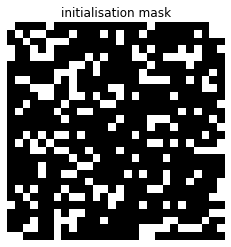

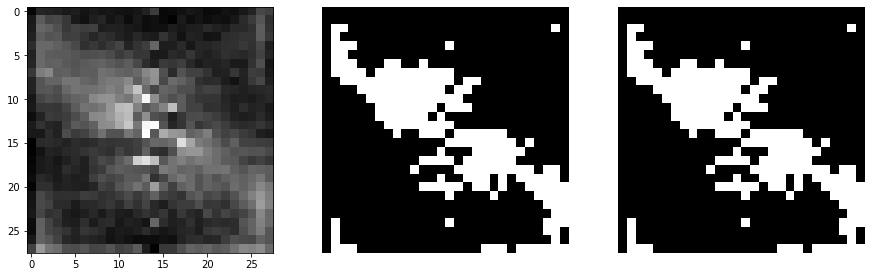


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.1877








































































































































































































Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.1748








































































































































































































Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.1532




































































test at the end of epoch









































Test set: Avg. loss: 0.1427


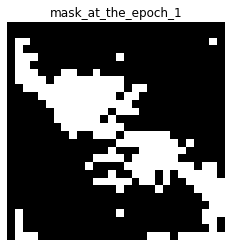

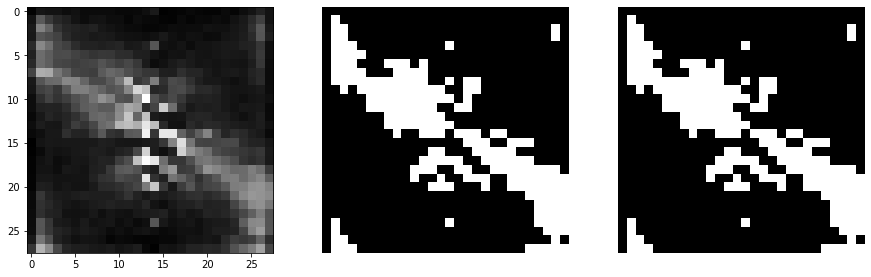


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.1515








































































































































































































Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.1625








































































































































































































Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.1645




































































test at the end of epoch









































Test set: Avg. loss: 0.1516


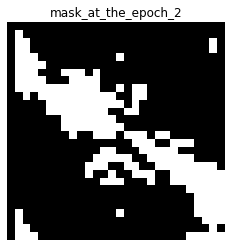

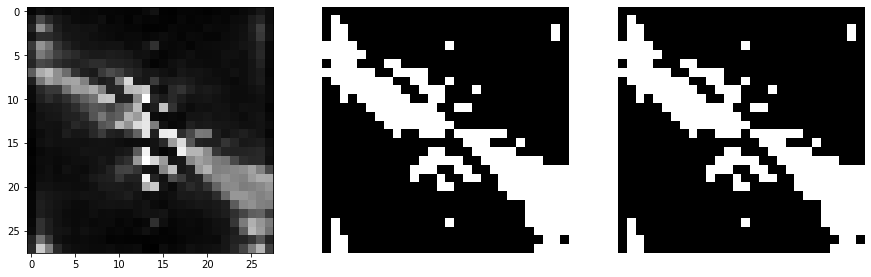


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.1493








































































































































































































Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.1546








































































































































































































Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.1646




































































test at the end of epoch









































Test set: Avg. loss: 0.1515


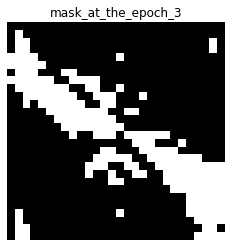

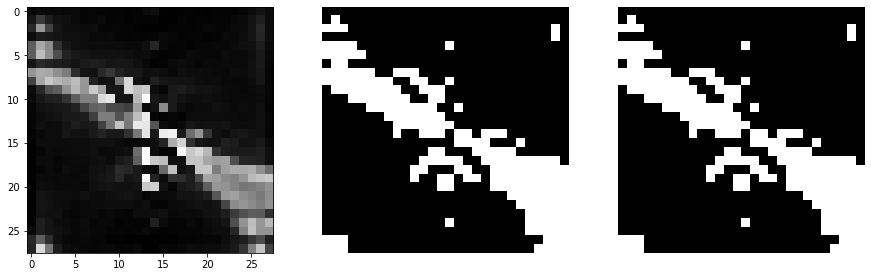


Train Epoch: 5 [0/60000 (0%)]	Loss: 0.1560








































































































































































































Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.1729








































































































































































































Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.1706




































































test at the end of epoch









































Test set: Avg. loss: 0.1598


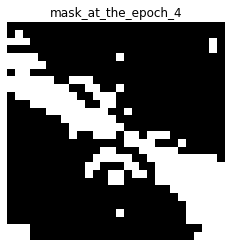

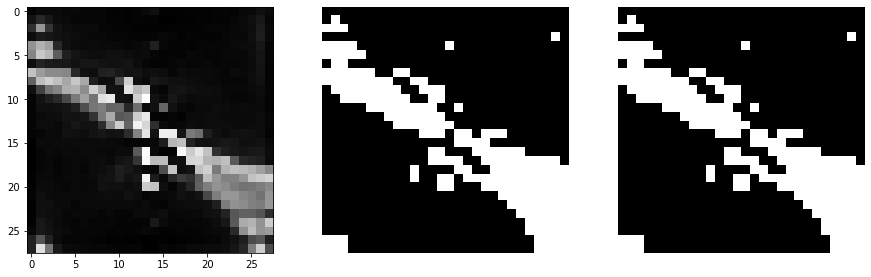

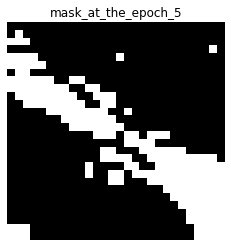

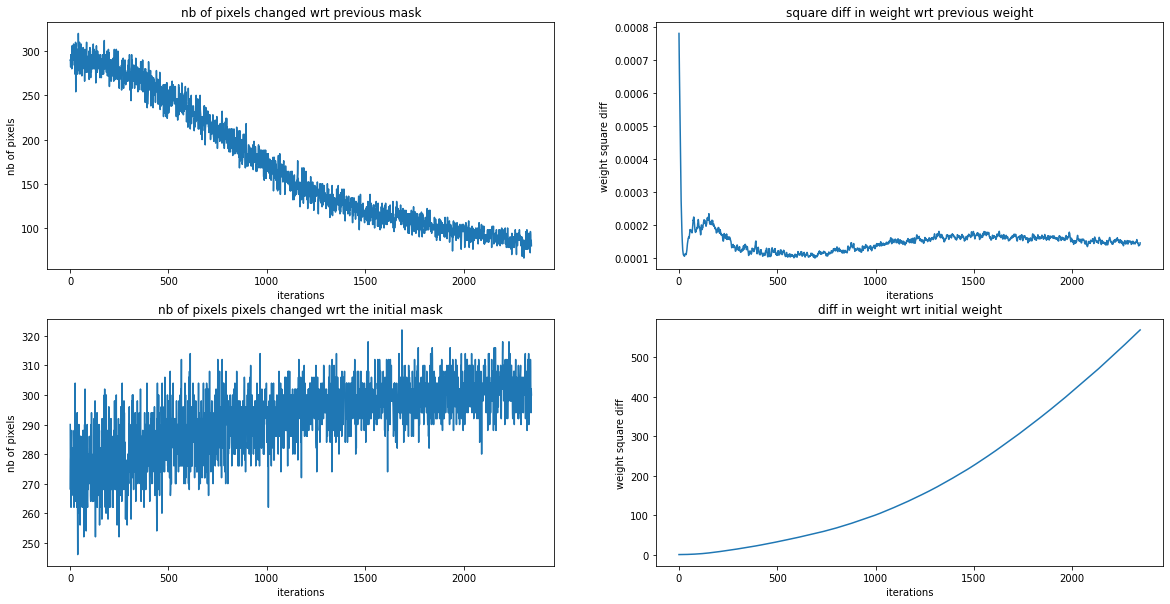

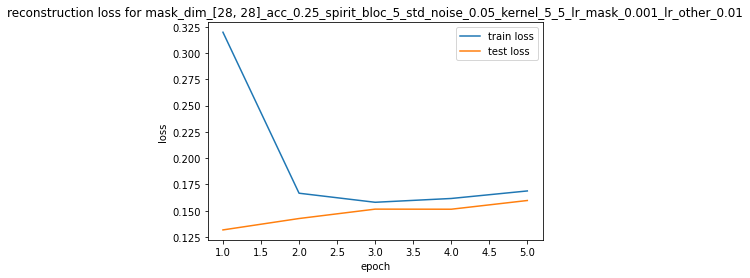

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")











































Test set: Avg. loss: 0.1598


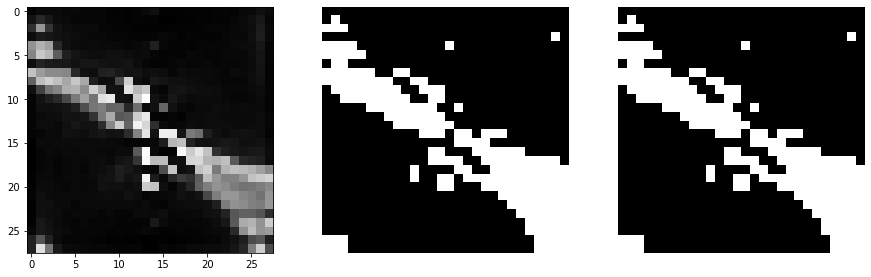

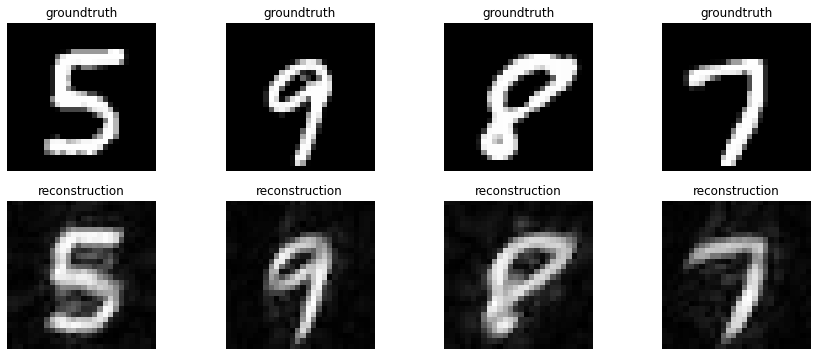

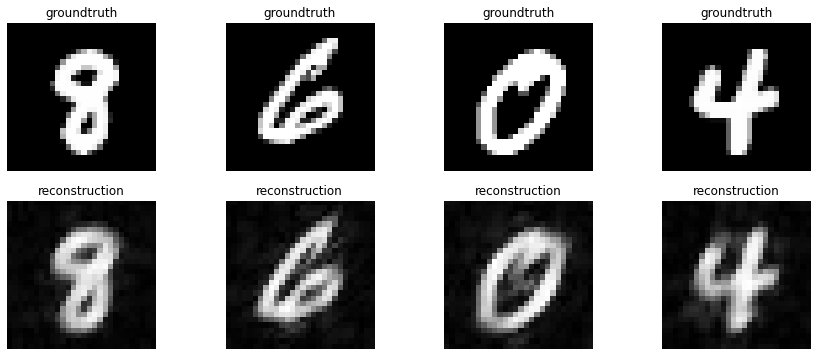

average ssim and psnr on test set {'test_ssim': 0.7284594839936068, 'test_psnr': 16.58636236858509}
##########   FIN   ##########


In [28]:
config = {"std_noise": 0.05,
 "dropout_proba": 0.0,
 "acc":0.25 ,
 "mask_dim": [28, 28], 
 "slope": 1,
 "slice_dim": [28, 28], 
 "main_directory": "./result", 
 "spirit_block": 5, 
 "kernel1": [5, 5], 
 "ncoils": 1, 
 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 0.001, "lr_other": 0.01, "auxiliary": False, "shift_type":"tr_img_ksp",
 "normalized_mse" : True,
 "n_epochs":5}

run_model(config)

max on train data [311.69804016] 
 min on train data [0.]
#################################################################
mask_dim_[28, 28]_acc_0.25_spirit_bloc_5_std_noise_0.05_kernel_5_5_lr_mask_0.1_lr_other_0.001
Number of acquired points in the whole mask : 196
Number of acquired points in the local mask of size [28, 28] : 196
acceleration : 0.25

torch.Size([128, 1, 28, 28, 2])



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.0112








































































































































































































Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.4328








































































































































































































Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.3613




































































test at the end of epoch









































Test set: Avg. loss: 0.3146


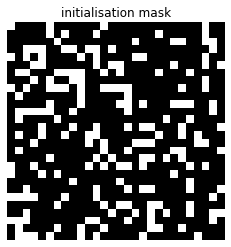

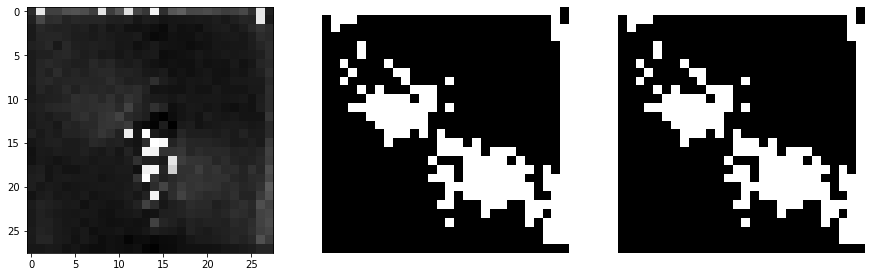

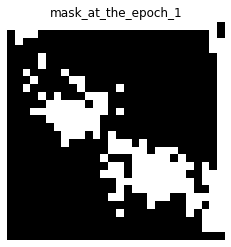

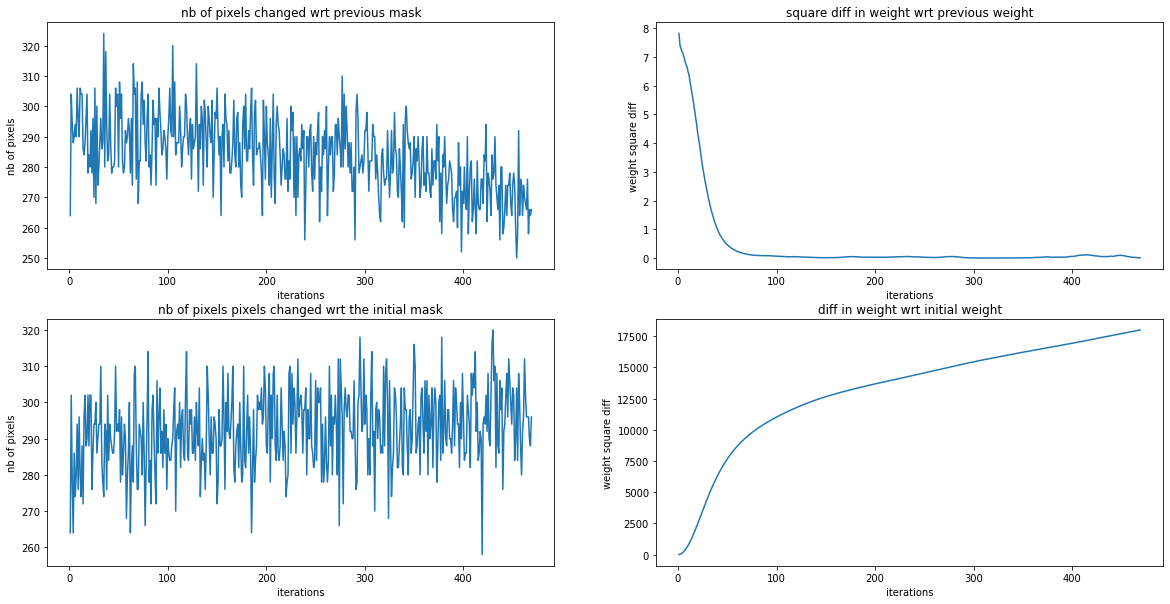

dictionay['test_loss'] [0.3145647644996643]


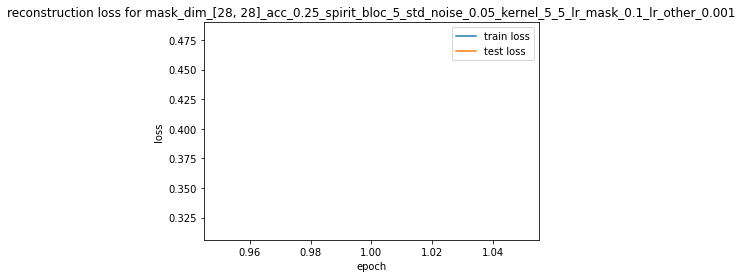

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")











































Test set: Avg. loss: 0.3146


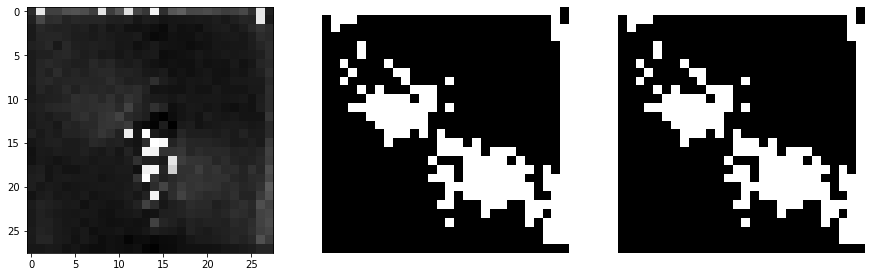

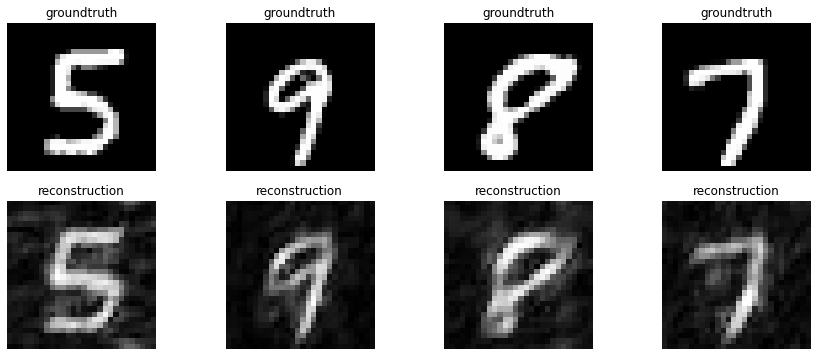

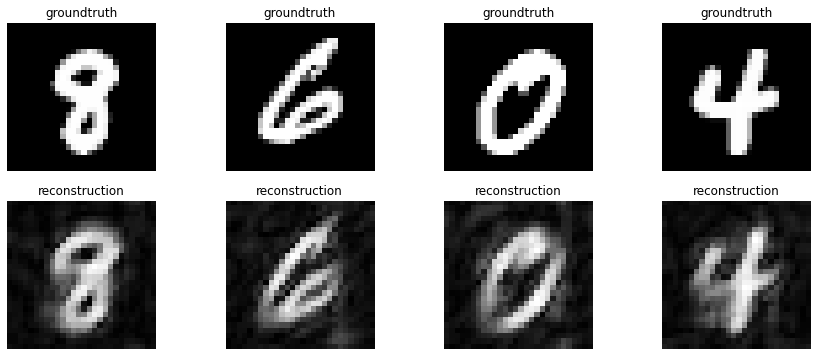

average ssim and psnr on test set {'test_ssim': 0.5614675355254759, 'test_psnr': 13.302975398773453}
##########   FIN   ##########


In [52]:
config_2 = {"std_noise": 0.05,
 "dropout_proba": 0.0,
 "acc":0.25 ,
 "mask_dim": [28, 28], 
 "slope": 1,
 "slice_dim": [28, 28], 
 "main_directory": "./result", 
 "spirit_block": 5, 
 "kernel1": [5, 5], 
 "ncoils": 1, 
 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 0.1, "lr_other": 0.001, "auxiliary": False, "shift_type":"tr_img_ksp",
 "normalized_mse" : True,
 "n_epochs":1}

run_model(config_2)

max on train data [311.69804016] 
 min on train data [0.]
#################################################################
mask_dim_[4, 4]_acc_0.25_spirit_bloc_5_std_noise_0.05_kernel_5_5_lr_mask_0.1_lr_other_0.001
Number of acquired points in the whole mask : 196
Number of acquired points in the local mask of size [4, 4] : 4
acceleration : 0.25

torch.Size([128, 1, 28, 28, 2])



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.9306








































































































































































































Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.4352








































































































































































































Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.3966




































































test at the end of epoch









































Test set: Avg. loss: 0.3617


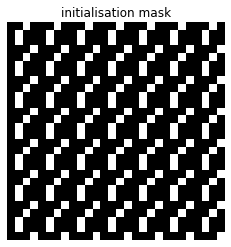

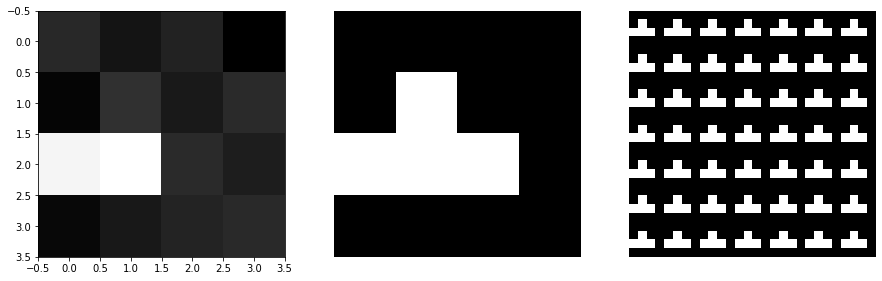

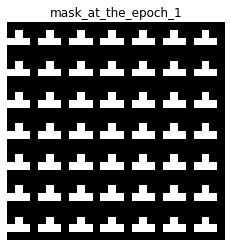

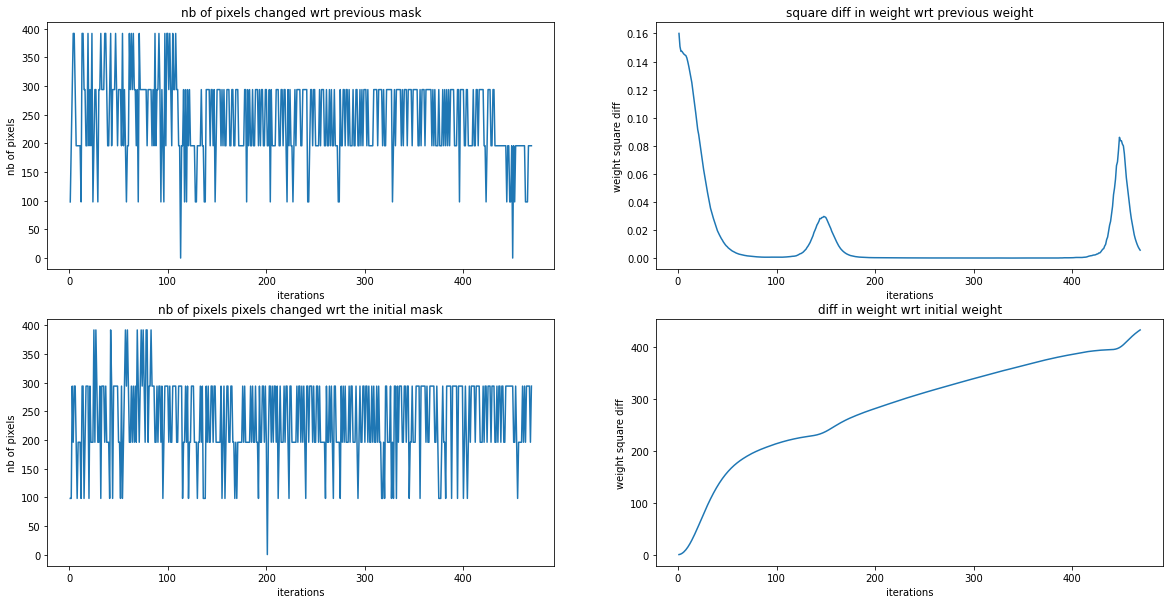

dictionay['test_loss'] [0.3616820275783539]


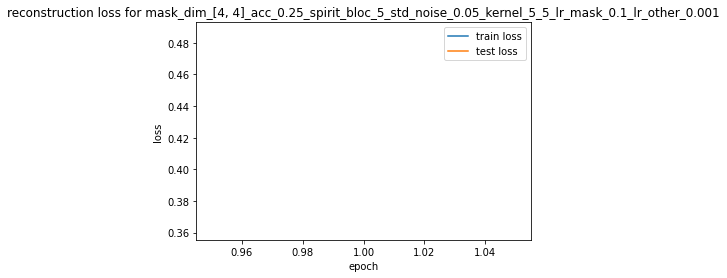

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")











































Test set: Avg. loss: 0.3617


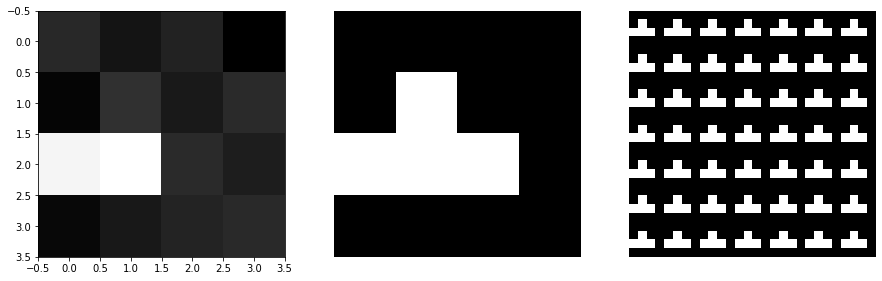

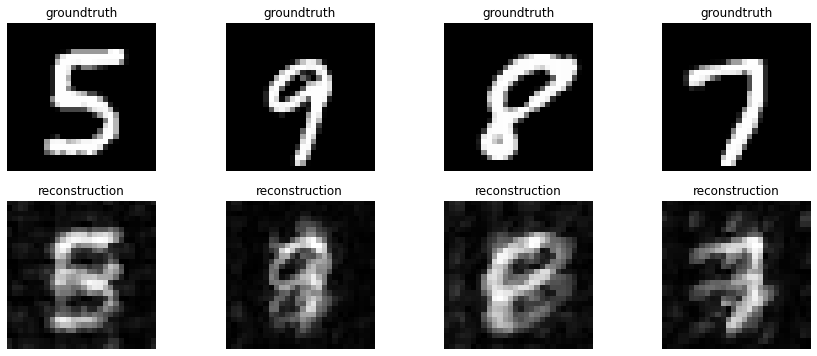

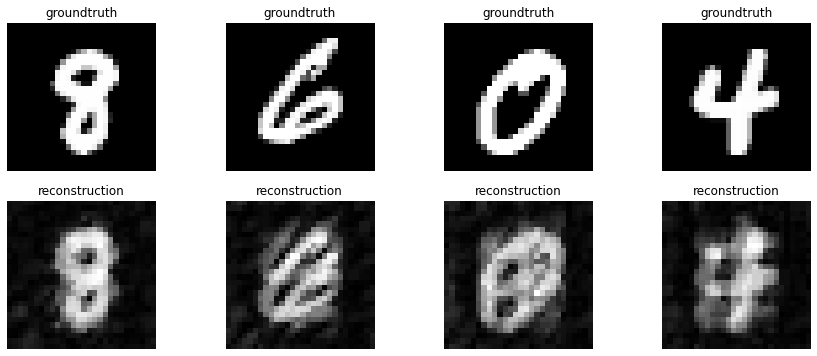

average ssim and psnr on test set {'test_ssim': 0.47932992599514634, 'test_psnr': 11.714214953523951}
##########   FIN   ##########


In [53]:
config_2 = {"std_noise": 0.05,
 "dropout_proba": 0.0,
 "acc":0.25 ,
 "mask_dim": [4, 4], 
 "slope": 1,
 "slice_dim": [28, 28], 
 "main_directory": "./result", 
 "spirit_block": 5, 
 "kernel1": [5, 5], 
 "ncoils": 1, 
 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 0.1, "lr_other": 0.001, "auxiliary": False, "shift_type":"tr_img_ksp",
 "normalized_mse" : True,
 "n_epochs":1}

run_model(config_2)

## Fixed mask

In [ ]:
def create_mask(size, acceleration, typ, submask_size = (4,4),seed = None):
    """Create fixed mask pattern. This works finely for acceleration = 2 ie R =4 or 25% of data. For others acceleration, this doesn't work well."""
    num_cols = size[-1] 
    num_rows = size[-2]
    
        #acs_start = (num_cols - acs_lines + 1) // 2

    if typ=='uniform':

        mask_col = np.zeros(num_cols, dtype=bool)
        mask_col[::acceleration*2] = True
        ones = np.ones((num_rows,num_cols))
        mask = np.multiply(ones, mask_col)

    if typ == "2D_uniform":

        mask_row = np.zeros(num_rows, dtype=bool)
        mask_row[::acceleration] = True 
        mask_row ## indicates which lines in the first column are set to true or false

        mask_row = mask_row[:,None]
        mask_row

        mask_col = np.zeros(num_cols ,dtype=bool) ##indicate if each column has some acquired points or not at all
        mask_col[::acceleration] = True
        mask_col = np.tile(mask_col,(num_rows,1))
        mask_col

        mask = np.multiply(mask_row, mask_col)
        
    
    if typ == "caipiranha":

        ## caipiranha sampling mask , see https://mriquestions.com/caipirinha.html

        ##the goal is to build a small matrix (shape :(num_rows,accelaration)) which has a caipiranha pattern and then apply it to shape of the data

        mask_row = np.zeros(num_rows ,dtype=bool)
        mask_row[::acceleration] = True 
        mask_row = mask_row[:,None] ## indicates which lines in the first column are set to true or false

        mask_col = np.zeros(acceleration*2 ,dtype=bool)
        mask_col[::acceleration] = True
        mask_col = np.tile(mask_col,(num_rows,1))
        mask_col  ##assign true or false to each column

        dd = np.multiply(mask_row, mask_col) ##replecate the first column at columns which are set to true. dd is our small matrix that has a caipiranha pattern

        replace=(dd == False)[:,acceleration]  ## make a sampling shift : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3865024/ paragraph CAIPIRINHA Theory

        dd[:,acceleration] = replace

        mask = np.tile(dd,int(np.ceil(num_cols/dd.shape[1]))) ##replicate this matrix 

        mask = mask[:,:num_cols] #apply it to shape of the data
        #mask

    if typ == "random":

      k_per_under_mask = (submask_size[0]*submask_size[1])//4

      np.random.seed(seed)

      ##for the proportion we need to find the proportion of 1 we will have in a reference submask
      #https://stackoverflow.com/questions/19597473/binary-random-array-with-a-specific-proportion-of-ones

      #mask = np.random.choice([1, 0], size= size, p=[(acceleration*acceleration)/(submask_size[0]*submask_size[1]) , 1 - (acceleration*acceleration)/(submask_size[0]*submask_size[1])] )

      mask = np.array( [0] * (submask_size[0]*submask_size[1] - k_per_under_mask) + [1] * (k_per_under_mask) )
      
      np.random.shuffle(mask); mask = mask.reshape((submask_size[0],submask_size[1])); 

      mask = np.tile(mask, (math.ceil(num_rows/submask_size[0]),math.ceil(num_cols/submask_size[1])))[:num_rows,:num_cols] 

    return mask

Text(0.5, 1.0, 'random')

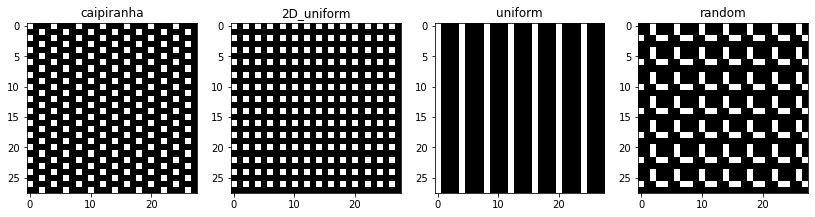

In [ ]:
##une acceleration de 2 pour caipiranha et 2D_uniform correspond à une acceleration de 4 pour uniforme
fig, ax = plt.subplots(1,4, figsize = (14,8))

ax[0].imshow( create_mask( (28, 28) , acceleration =2 , typ="caipiranha" ) ,cmap = "Greys_r")
ax[0].set_title("caipiranha")

ax[1].imshow( create_mask( (28, 28)  , acceleration =2 , typ="2D_uniform" ) ,cmap = "Greys_r")
ax[1].set_title("2D_uniform") 

ax[2].imshow( create_mask( (28, 28) , acceleration =2 , typ="uniform" ) ,cmap = "Greys_r")
ax[2].set_title("uniform")

ax[3].imshow( create_mask( (28, 28) , acceleration =2 , typ="random" ) ,cmap = "Greys_r")
ax[3].set_title("random")


Text(0.5, 1.0, 'random')

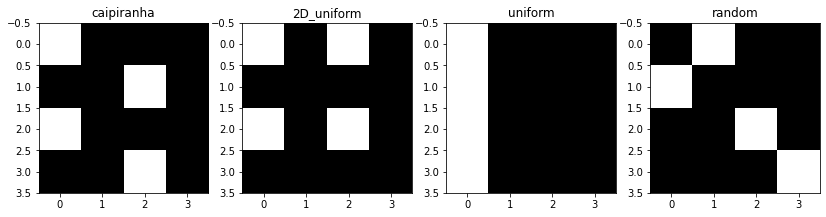

In [ ]:
mask_caipiranha = create_mask( (4, 4) , acceleration =2 , typ="caipiranha" )

mask_2D_uniform = create_mask( (4, 4) , acceleration =2 , typ="2D_uniform" )

mask_uniform = create_mask( (4, 4) , acceleration =2 , typ="uniform" )

a_mask_random = create_mask( (4, 4) , acceleration =2 , typ="random" )

fig, ax = plt.subplots(1,4, figsize = (14,8)) 

ax[0].imshow( mask_caipiranha ,cmap = "Greys_r")
ax[0].set_title("caipiranha")

ax[1].imshow( mask_2D_uniform ,cmap = "Greys_r")
ax[1].set_title("2D_uniform") 

ax[2].imshow( mask_uniform ,cmap = "Greys_r")
ax[2].set_title("uniform")

ax[3].imshow(a_mask_random ,cmap = "Greys_r")
ax[3].set_title("random")

## Define the reconstruction model with fixed mask

In [ ]:

class FixmaskNet(nn.Module):

    def __init__(self, masque, config=None):
        super(FixmaskNet, self).__init__()

        self.img_h = config.slice_dim[0]
        self.img_w = config.slice_dim[1]

        self.height_mask = masque.shape[0]
        self.width_mask = masque.shape[1]

        self.config = config

        self.spirit_nn = ComplexstackSpirit(self.config) 
        
        self.masque = torch.reshape(torch.from_numpy(masque), (1, 1, self.height_mask, self.width_mask)).float().to(device)

        self.masque_adj = torch.tile(self.masque[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28

        self.masque_adj = torch.tile(self.masque[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28

        self.stack_binary_mask_adj = torch.stack((self.masque_adj, self.masque_adj), dim=-1,)

    def forward(self, x):

        x  = torch.mul(self.stack_binary_mask_adj, x)

        reconstructed_img = self.spirit_nn(x, self.stack_binary_mask_adj) ##more precisely it is the reconstructed kspace  
          
        return reconstructed_img , self.masque_adj, self.masque  


## Run model for fixed masks

In [ ]:

def run_fix_mask_model_2(config, trainset= X_mnist_train, testset = X_mnist_test, critere = nn.MSELoss().to(device)):
    
    config = edict(config.copy()) 
    
    dir_name = f"mask_typ_{config.mask_typ}_mask_dim_{config.mask_dim[0]}_{config.mask_dim[1]}_spirit_bloc_{config.spirit_block}_kernel_{config.kernel1[0]}_{config.kernel1[1]}_lr_other_{config.lr_other}"
    
    
    try:
        os.mkdir(config.main_directory) ##this will be created once, the others times an error will occur due to the multiplication of config that will need to create it again
    except:
        pass
        

    try:
        save_path = os.path.join(config.main_directory, dir_name)
        os.mkdir(save_path)  
    except:
        pass


    mask = create_mask(config.mask_dim, acceleration=2, typ=config.mask_typ, submask_size = (4,4),seed = config.mask_seed)
    
    print("#################################################################")                          

    print(f"mask_typ_{config.mask_typ}_mask_dim_{config.mask_dim}_spirit_bloc_{config.spirit_block}_lr_other_{config.lr_other}_kernel_{config.kernel1}")
    
    
    df = pd.DataFrame(columns=['mask_typ','mask_dim','bloc', 'kernel','lr_other','test_ssim','test_psnr','test_loss','test_loss_denorm'])
    
        
    reconst_network = FixmaskNet(mask, config = config).to(device)

    train_loader, test_loader, input_scaler = transform_data(trainset, testset, config)

    optimizer = optim.Adam(reconst_network.parameters(), lr= config.lr_other)
    
    print("start running")

    history = train_spirit_2(config.n_epochs, network = reconst_network,optimizer = optimizer,config = config, loader =train_loader, loader_test= test_loader, scaler = input_scaler, criterion=critere, saving_path = save_path ,fix_mask = True)

    
    plot_loss(history, title=f"reconstruction loss_spirit_bloc_{config.spirit_block}_lr_other_{config.lr_other}_kernel_{config.kernel1[0]}_{config.kernel1[1]}", test=False, saving_path = os.path.join(save_path,"loss_curve.png") )

    test_input, test_output,test_loss, finalmask = test_spirit_2(reconst_network,criterion=critere, config =config, loader = test_loader,scaler = input_scaler, fix_mask = True)    


    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 815, saving_path =os.path.join(save_path,"reconst_examples1.png"))
    
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 23, saving_path =os.path.join(save_path,"reconst_examples2.png"))

    metrics = compute_ssim(test_input ,test_output)
    
    test_loss_denorm = critere(torch.from_numpy(test_input), torch.from_numpy(test_output)).item()

    print("average ssim and psnr on test set", metrics)
    
    line ={"mask_typ":config.mask_typ,"mask_dim":config.mask_dim ,"bloc" : config.spirit_block, "kernel" :config.kernel1,"lr_other": config.lr_other}

    line.update(metrics); line["test_loss"] = test_loss ; line["test_loss_denorm"] = test_loss_denorm

    df = df.append(line, ignore_index=True) 

    df.to_csv(os.path.join(config.main_directory, dir_name ,"result_grid_search.csv"), sep='\t',index=True)           

    #config_current = edict(initial_config.copy())  

    print("##########   FIN   ##########")

In [ ]:
config_fixed = {"std_noise": 0.05,
                "mask_dim": [4, 4],
                "slope": 1, 
                "slice_dim": [28, 28], 
                "main_directory": "./result",
                "spirit_block": 5, 
                "kernel1": [5, 5],
                "ncoils": 1,
                "spirit_activation": "none",
                "batch_norm": False,
                "lr_other": 0.01, "acceleration": 2, 
                "auxiliary": False, "mask_typ": "caipiranha", "mask_seed": None, "shift_type":"tr_img_ksp"}


#################################################################
mask_typ_caipiranha_mask_dim_[4, 4]_spirit_bloc_5_lr_other_0.01_kernel_[5, 5]
max on train data [311.69804016] 
 min on train data [0.]
start running
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.0005
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


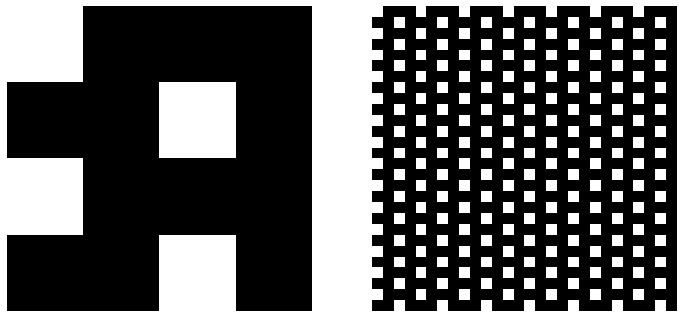

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


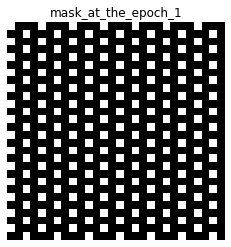

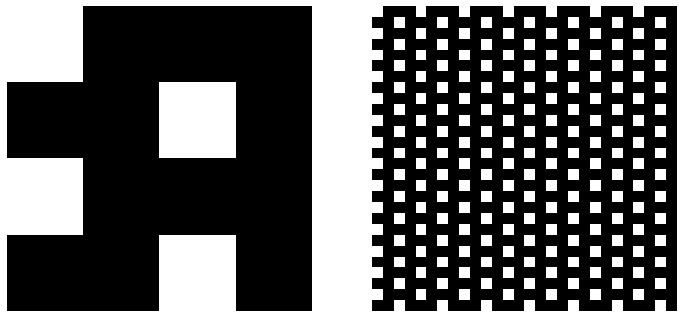

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


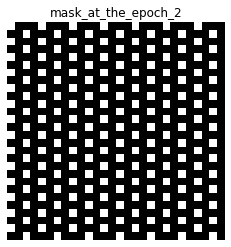

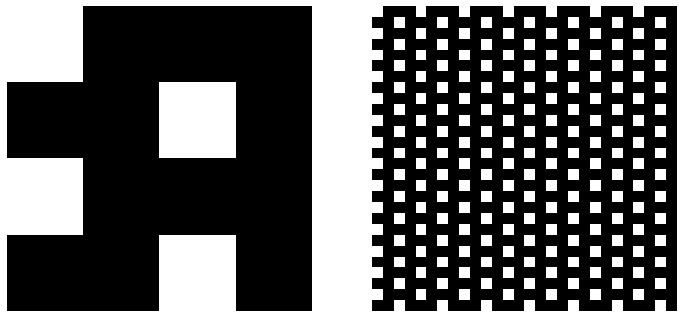

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


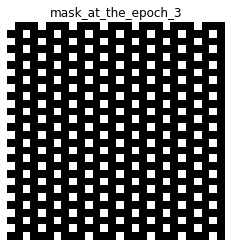

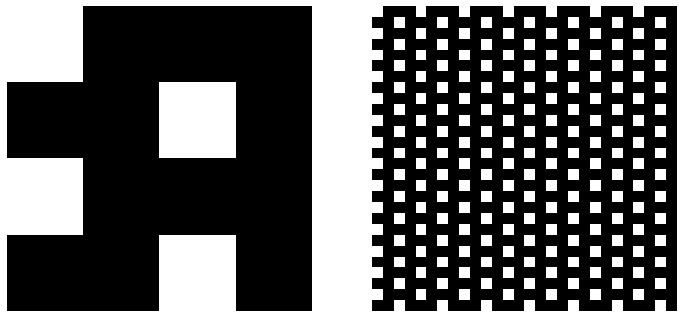

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


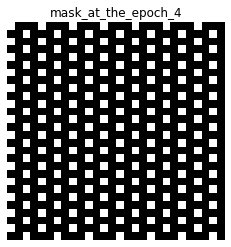

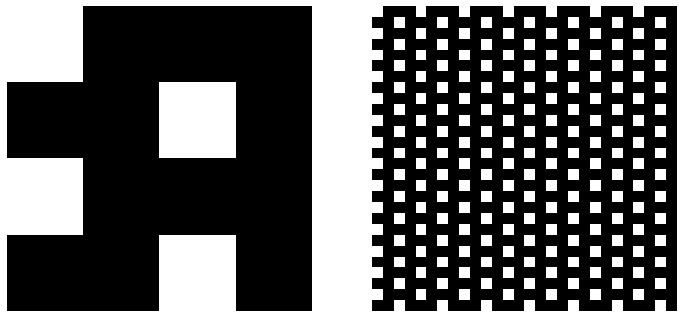

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


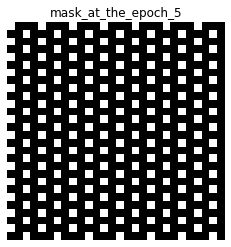

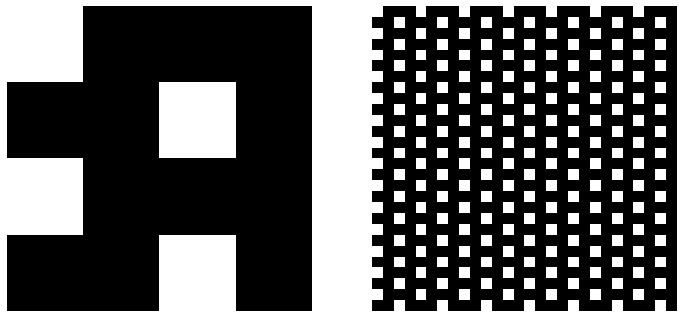

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


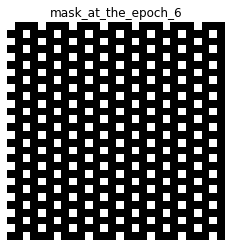

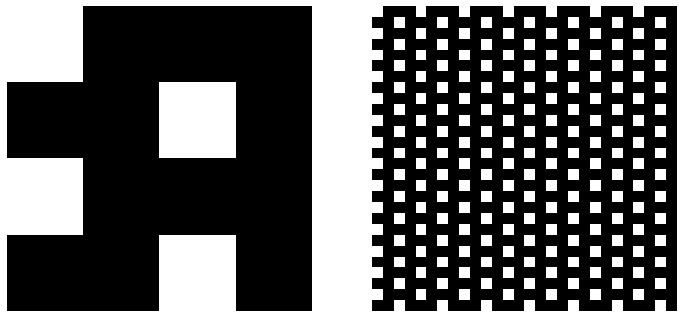

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


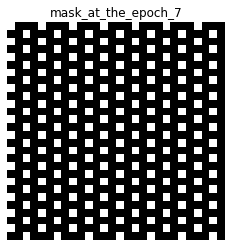

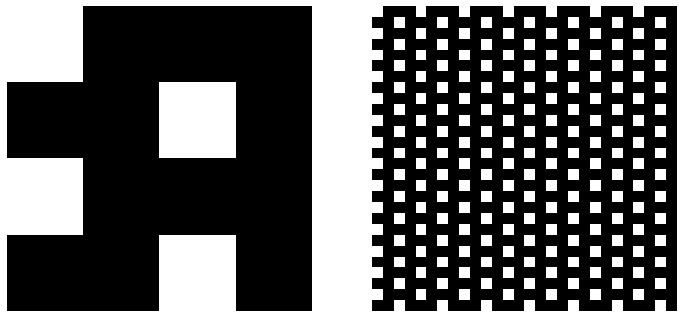

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


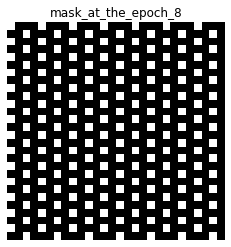

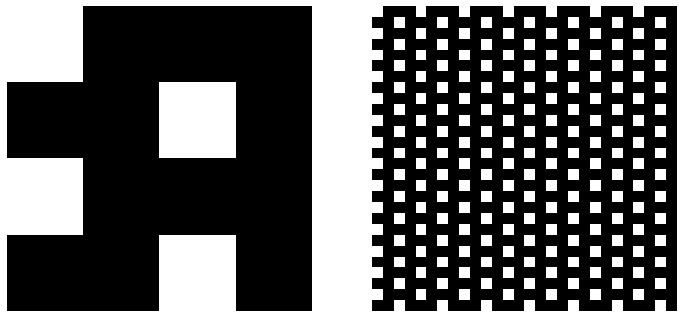

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0002
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0002
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0002
test at the end of epoch

Test set: Avg. loss: 0.0002


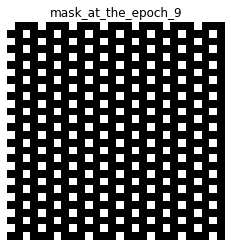

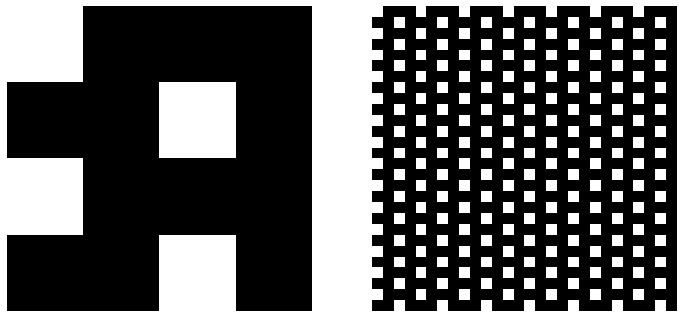

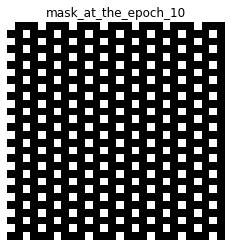

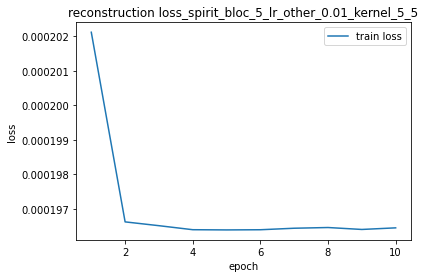


Test set: Avg. loss: 0.0002


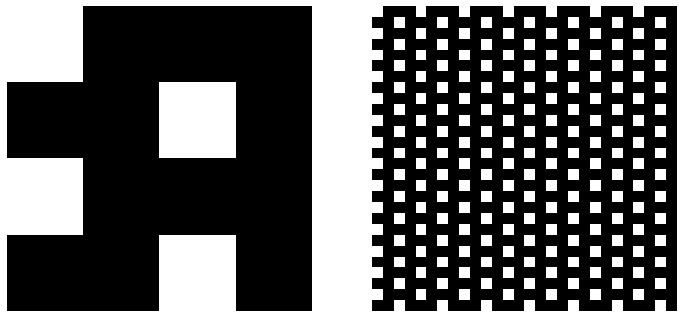

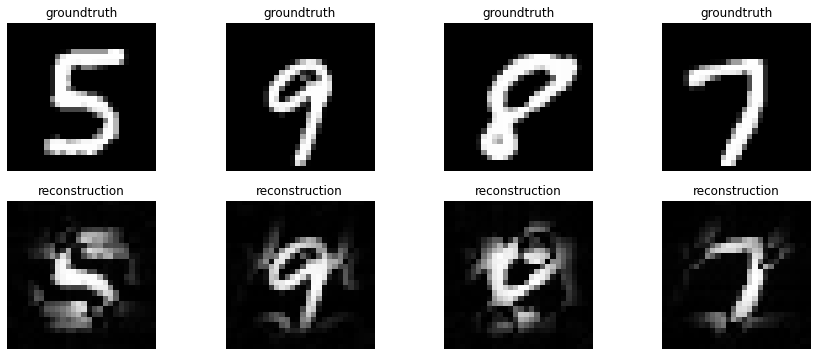

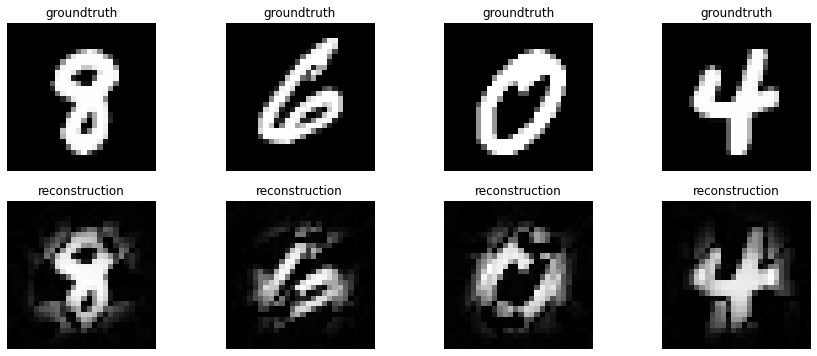

average ssim and psnr on test set {'test_ssim': 0.5302768430791172, 'test_psnr': 11.85298378962379}
##########   FIN   ##########


<ipython-input-26-5bc2c6119aad>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(line, ignore_index=True)


In [ ]:
run_fix_mask_model_2(config_fixed, trainset= X_mnist_train, testset = X_mnist_test, critere = nn.MSELoss().to(device))